In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix

In [62]:
# CONFIGURACIÓN
SEED = 42
pd.set_option('display.max_columns', None)

# Umbral de decisión (Ajustable: > 0.5 para más precisión, < 0.5 para más recall)
UMBRAL_CORTE = 0.6752

# RUTA A LA CARPETA DE DATOS
DATA_DIR = 'Data/'



In [63]:
# Archivos

MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'


In [64]:
# Parámetros Modelo GENERAL (Optimizados)
PARAMS_GENERAL = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": 3400,
        "learning_rate": 0.00691672678053923,
        "max_depth": 8,
        "min_child_weight": 2,
        "subsample": 0.70040916883059,
        "colsample_bytree": 0.6336372737535174,
        "gamma": 4.444773501115239,
        "reg_alpha": 0.0364624837974602,
        "reg_lambda": 9.704572224997422,
        "scale_pos_weight": 2.636601227452452,
        "colsample_bylevel": 0.6165801944134792,
        "max_delta_step": 8
    }

# Parámetros Modelo CHILE (Optimizados)
PARAMS_CHILE = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": 2200,
        "learning_rate": 0.019391819588103883,
        "max_depth": 8,
        "min_child_weight": 1,
        "subsample": 0.9752595713301466,
        "colsample_bytree": 0.6328798712612868,
        "gamma": 2.9814556867287916,
        "reg_alpha": 6.387337415800881,
        "reg_lambda": 1.1820890927398913,
        "scale_pos_weight": 2.011233074090613,
        "colsample_bylevel": 0.6400362283520091,
        "max_delta_step": 8
    }

PARAMS_PERU = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": 3100,
        "learning_rate": 0.009235446685142758,
        "max_depth": 10,
        "min_child_weight": 4,
        "subsample": 0.9017111792136994,
        "colsample_bytree": 0.6743347806102663,
        "gamma": 4.297137520936097,
        "reg_alpha": 3.7448303335872772,
        "reg_lambda": 0.15238863400797806,
        "scale_pos_weight": 2.201108125519425,
        "colsample_bylevel": 0.6655298507617331,
        "max_delta_step": 3
    }
PARAMS_ARGENTINA = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": 1000,
        "learning_rate": 0.018998851797390533,
        "max_depth": 3,
        "min_child_weight": 5,
        "subsample": 0.6747902887051281,
        "colsample_bytree": 0.7516384622236544,
        "gamma": 4.470409712877202,
        "reg_alpha": 0.04101651068522135,
        "reg_lambda": 6.219491591918364,
        "scale_pos_weight": 3.843229634647292,
        "colsample_bylevel": 0.8089365029457853,
        "max_delta_step": 8
    }
PARAMS_COLOMBIA = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": 4300,
        "learning_rate": 0.010471126653741473,
        "max_depth": 4,
        "min_child_weight": 4,
        "subsample": 0.8596201893305959,
        "colsample_bytree": 0.6815054348181652,
        "gamma": 4.754798017045593,
        "reg_alpha": 0.1078806769711471,
        "reg_lambda": 6.518705024436593,
        "scale_pos_weight": 3.3804314446366885,
        "colsample_bylevel": 0.7867103909203,
        "max_delta_step": 0
    }


parametros = {
    "General": PARAMS_GENERAL,
    "Chile": PARAMS_CHILE,
    "Peru": PARAMS_PERU,
    "Argentina": PARAMS_ARGENTINA,
    "Colombia": PARAMS_COLOMBIA,
}


In [65]:
def entrenar_modelo_visual(X_train, X_test, y_train, y_test, nombre_modelo, params_fijos, top_n_importance=15):
    print(f" PROCESANDO MODELO: {nombre_modelo}")

    # 1. Configuración y Entrenamiento del XGBoost
    model = XGBClassifier(**params_fijos)
    print("-> Entrenando XGBoost...")
    model.fit(X_train, y_train)

    # 2. Evaluación
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs > UMBRAL_CORTE).astype(int)
    auc = roc_auc_score(y_test, probs)

    precision_1 = precision_score(y_test, preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, preds, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, preds, pos_label=1, zero_division=0)

    precision_0 = precision_score(y_test, preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, preds, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, preds, pos_label=0, zero_division=0)

    print(f"\n--- RESULTADOS: {nombre_modelo} ---")
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test, preds, target_names=['Ocio (0)', 'Trabajo (1)']))

    metrics = {
        'ROC-AUC': auc,
        'Precision_1': precision_1, 'Recall_1': recall_1, 'F1-Score_1': f1_1,
        'Precision_0': precision_0, 'Recall_0': recall_0, 'F1-Score_0': f1_0
    }

    # 3. Gráficos (Matriz y ROC)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ocio', 'Trabajo'])
    disp.plot(ax=ax[0], cmap='Blues', values_format='d')

    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title(f'Curva ROC - {nombre_modelo}')
    ax[0].grid(False)
    plt.tight_layout()
    plt.show()

    # 4. Gráfica de importancia de features
    try:
        if hasattr(model, 'feature_importances_'):
            feat_names = X_train.columns.tolist() if isinstance(X_train, pd.DataFrame) else [f"f_{i}" for i in range(X_train.shape[1])]
            importances = model.feature_importances_
            df_imp = pd.DataFrame({'feature': feat_names, 'importance': importances})
            df_imp = df_imp.sort_values('importance', ascending=False).head(top_n_importance)
            # df_imp.copy().to_csv(f'Data/{nombre_modelo}.csv', index=False, sep=';')


            # plot horizontal bar with annotations
            fig2, ax2 = plt.subplots(figsize=(10, max(4, 0.4 * len(df_imp))))
            df_imp_plot = df_imp[::-1]  # invertir para que la más importante quede arriba
            bars = ax2.barh(df_imp_plot['feature'], df_imp_plot['importance'], color='C0')
            ax2.set_xlabel('Importancia')
            ax2.set_title(f'Importancia de features - {nombre_modelo} (top {len(df_imp)})')

            # Anotar cada barra (usa bar_label si disponible)
            try:
                ax2.bar_label(bars, fmt='%.3f', padding=6)
            except Exception:
                max_w = df_imp['importance'].max() if len(df_imp) else 1.0
                x_off = max_w * 0.01
                for bar in bars:
                    w = bar.get_width()
                    ax2.text(w + x_off, bar.get_y() + bar.get_height() / 2, f'{w:.3f}', va='center', ha='left', fontsize=9)

            plt.tight_layout()
            plt.show()
        else:
            print("Aviso: el modelo no tiene `feature_importances`, no se genera la gráfica de importancia.")
    except Exception as e:
        print("No se pudo generar la gráfica de importancia:", e)

    # 5. Devolver el modelo entrenado y las métricas
    return model, metrics

In [66]:
def matriz_correlacion_por_modelo(model_or_pipeline, X, feature_names=None, top_n=None, method='pearson', figsize=(24,12), cmap='coolwarm', target_name=None):
    # 1. Preparar DataFrame
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        if feature_names is None:
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # eliminar columna target si está presente
    if target_name is not None and target_name in df_X.columns:
        df_X = df_X.drop(columns=[target_name])

    # 2. Si es Pipeline, intentar aplicar scaler y extraer modelo final
    model = model_or_pipeline
    if isinstance(model_or_pipeline, Pipeline):
        # aplicar scaler si existe
        if 'scaler' in model_or_pipeline.named_steps:
            scaler = model_or_pipeline.named_steps['scaler']
            try:
                X_scaled = scaler.transform(df_X)
                df_X = pd.DataFrame(X_scaled, columns=df_X.columns)
            except Exception:
                pass
        # obtener estimador final si está nombrado 'model'
        model = model_or_pipeline.named_steps.get('model', model_or_pipeline)

    # 3. Selección top_n según coef_ o feature_importances_
    df_sel = df_X.copy()
    if top_n is not None:
        importances = None
        if hasattr(model, 'coef_'):
            try:
                importances = np.ravel(model.coef_)
            except Exception:
                importances = None
        if importances is None and hasattr(model, 'feature_importances_'):
            importances = np.ravel(model.feature_importances_)
        if importances is not None:
            # si hay desajuste de tamaño, truncar al mínimo
            if len(importances) != df_X.shape[1]:
                n = min(len(importances), df_X.shape[1])
                importances = importances[:n]
                df_sel = df_X.iloc[:, :n]
            # seleccionar top_n por importancia absoluta
            idx = np.argsort(np.abs(importances))[::-1][:top_n]
            selected_cols = [df_sel.columns[i] for i in idx]
            df_sel = df_sel[selected_cols]
        else:
            print("El modelo no tiene 'coef_' ni 'feature_importances_'. Se usarán todas las features.")

    # 4. Calcular matriz de correlación y plot
    corr = df_sel.corr(method=method)

    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1,
                square=True, cbar_kws={'shrink': .8}, annot_kws={'size':8})
    title_suffix = f"top_{top_n}" if top_n else "todas las features"
    plt.title(f"Matriz de correlación ({method}) - {title_suffix}")
    plt.tight_layout()
    plt.show()

    return corr

In [67]:
def graficar_importancia_features(pipeline, nombre_modelo, feature_names, top_n=15):
    # 1. Extraer modelo
    try:
        modelo_xgb = pipeline.named_steps['model']
    except KeyError:
        print(f"Error: No se encontró 'model' en el pipeline de {nombre_modelo}.")
        return

    # 2. Crear DataFrame de importancia usando los nombres de features proporcionados
    df_importancia = pd.DataFrame({
        'feature': feature_names,
        'importance': modelo_xgb.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)

    # 3. Graficar
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=df_importancia, palette='mako', hue='feature', legend=False)
    plt.title(f'Top {top_n} Características más Importantes - {nombre_modelo}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.tight_layout()
    plt.show()

### Modelo General

Cargando datos para el Modelo General...
 PROCESANDO MODELO: General
-> Entrenando XGBoost...

--- RESULTADOS: General ---
ROC-AUC: 0.7949
              precision    recall  f1-score   support

    Ocio (0)       0.83      0.91      0.86      2274
 Trabajo (1)       0.61      0.44      0.51       769

    accuracy                           0.79      3043
   macro avg       0.72      0.67      0.69      3043
weighted avg       0.77      0.79      0.77      3043



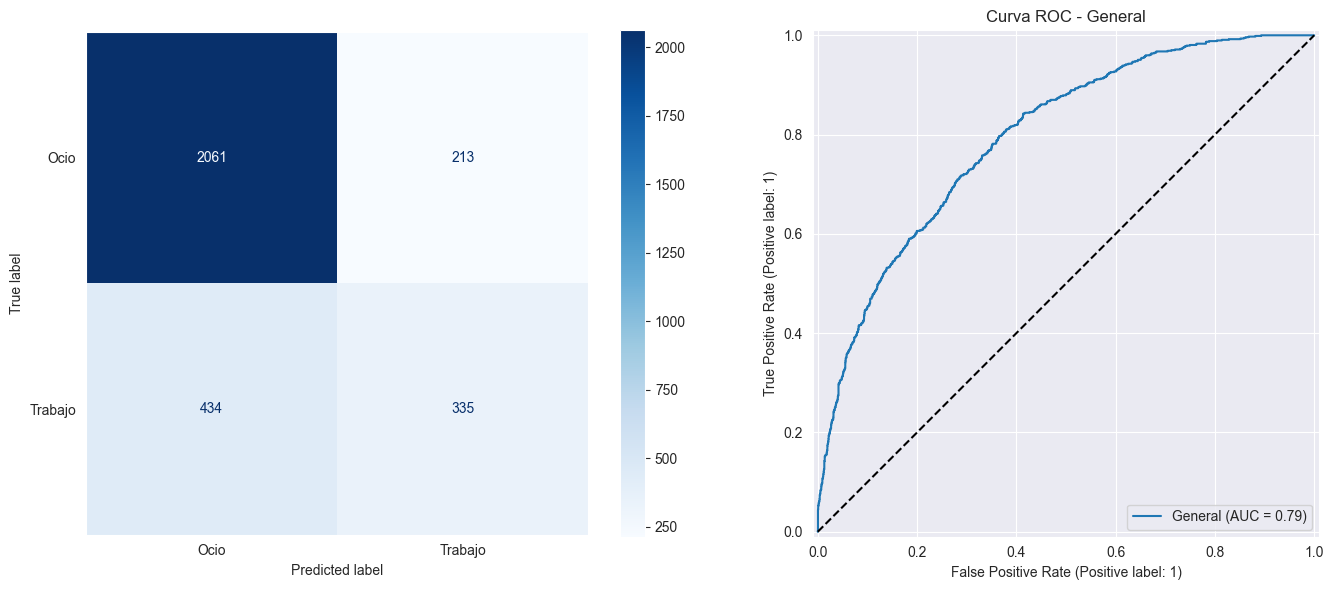

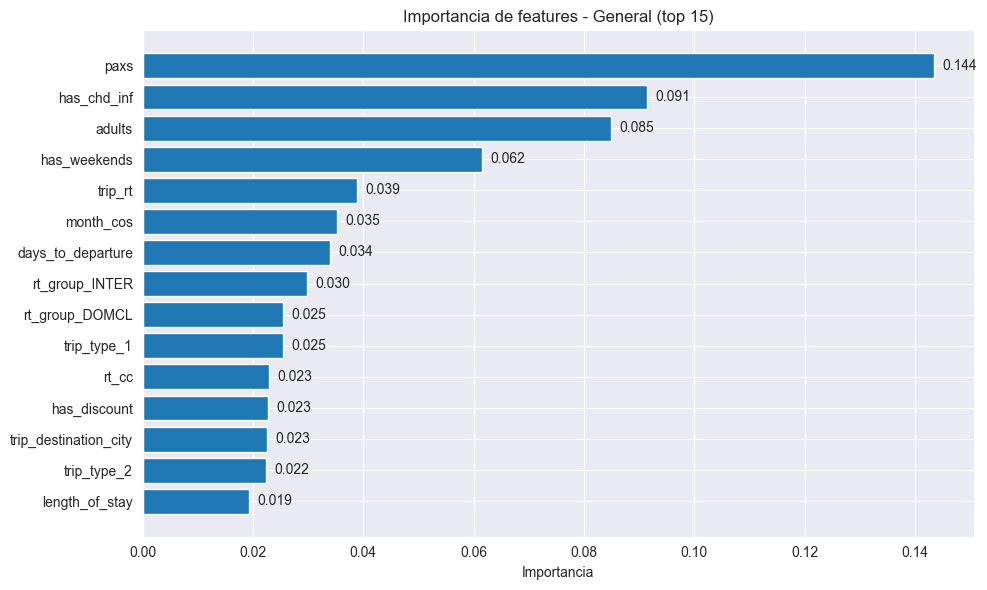

In [68]:
# --- Modelo General ---
print("Cargando datos para el Modelo General...")
X_train_gen = pd.read_parquet(f'{DATA_DIR}X_train_general_encoded.parquet')# .drop(['adults'], axis=1)
X_test_gen = pd.read_parquet(f'{DATA_DIR}X_test_general_encoded.parquet')# .drop(['adults'], axis=1)
y_train_gen = pd.read_pickle(f'{DATA_DIR}y_train_general.pkl')
y_test_gen = pd.read_pickle(f'{DATA_DIR}y_test_general.pkl')

modelo_general, metrics_general = entrenar_modelo_visual(
    X_train_gen, X_test_gen, y_train_gen, y_test_gen, "General", PARAMS_GENERAL
)

### Modelo Chile

Cargando datos para el Modelo Chile...
 PROCESANDO MODELO: Chile
-> Entrenando XGBoost...

--- RESULTADOS: Chile ---
ROC-AUC: 0.8655
              precision    recall  f1-score   support

    Ocio (0)       0.81      0.91      0.86       298
 Trabajo (1)       0.77      0.60      0.68       159

    accuracy                           0.80       457
   macro avg       0.79      0.75      0.77       457
weighted avg       0.80      0.80      0.79       457



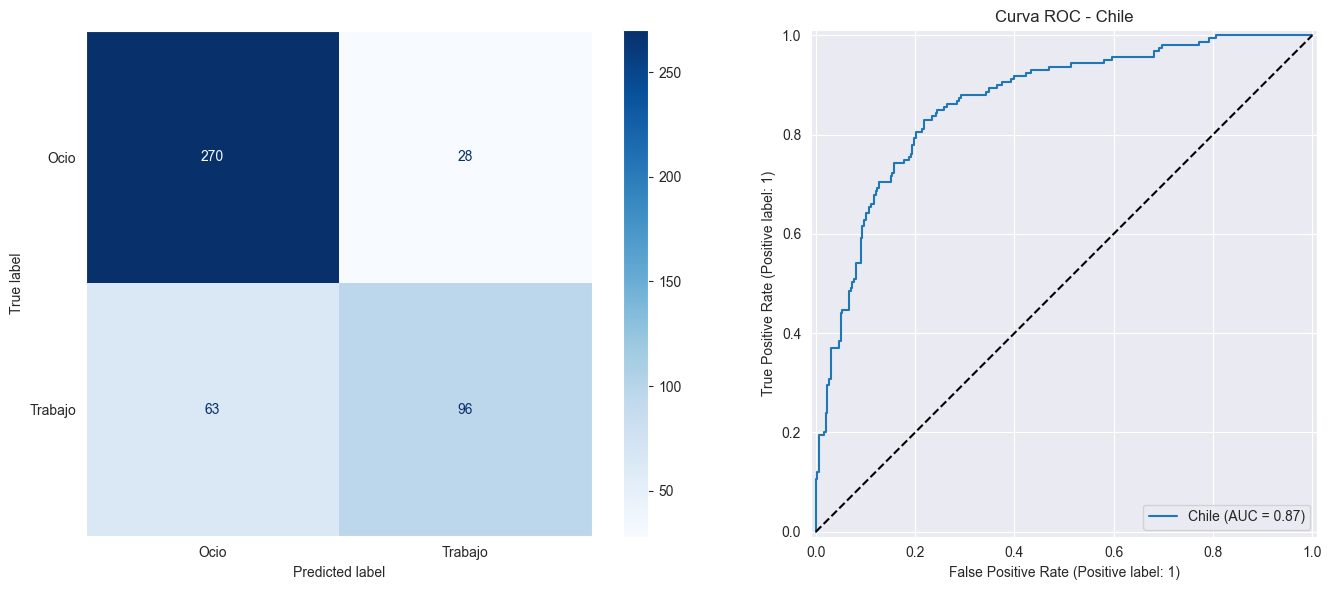

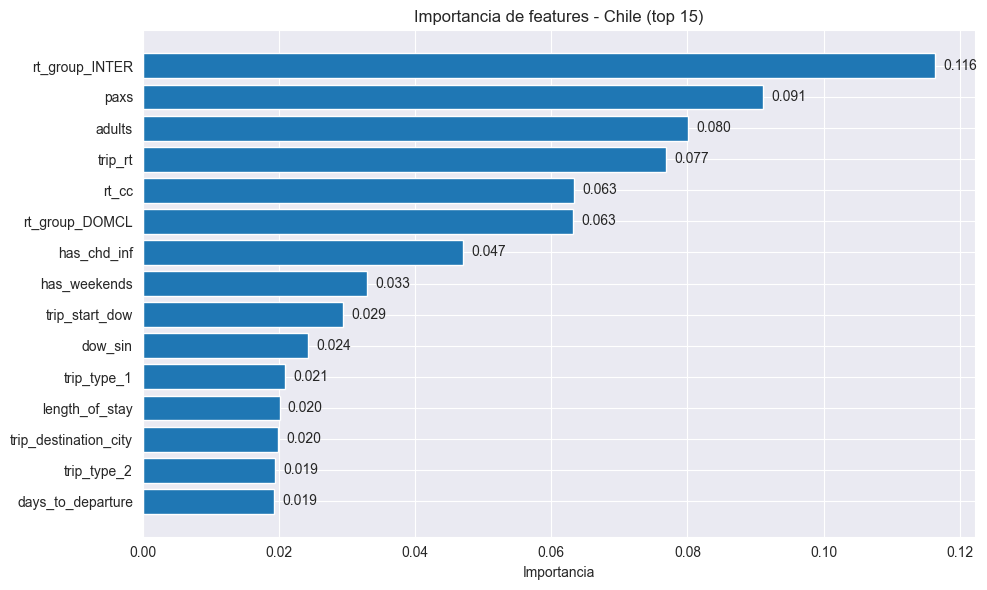

In [69]:
# --- Modelo Chile ---

print("Cargando datos para el Modelo Chile...")
X_train_cl = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')
X_test_cl = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')
y_train_cl = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test_cl = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')

modelo_chile, metrics_chile = entrenar_modelo_visual(
    X_train_cl, X_test_cl, y_train_cl, y_test_cl, "Chile", PARAMS_CHILE
)

In [70]:
# # --- Modelo INTER ---
#
# print("Cargando datos para el Modelo INTER...")
# X_train_in = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOIN}_encoded.parquet')
# X_test_in = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOIN}_encoded.parquet')
# y_train_in = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOIN}.pkl')
# y_test_in = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOIN}.pkl')
#
# modelo_inter, metrics_inter = entrenar_modelo_visual(
#     X_train_in, X_test_in, y_train_in, y_test_in, "Inter", PARAMS_GENERAL)

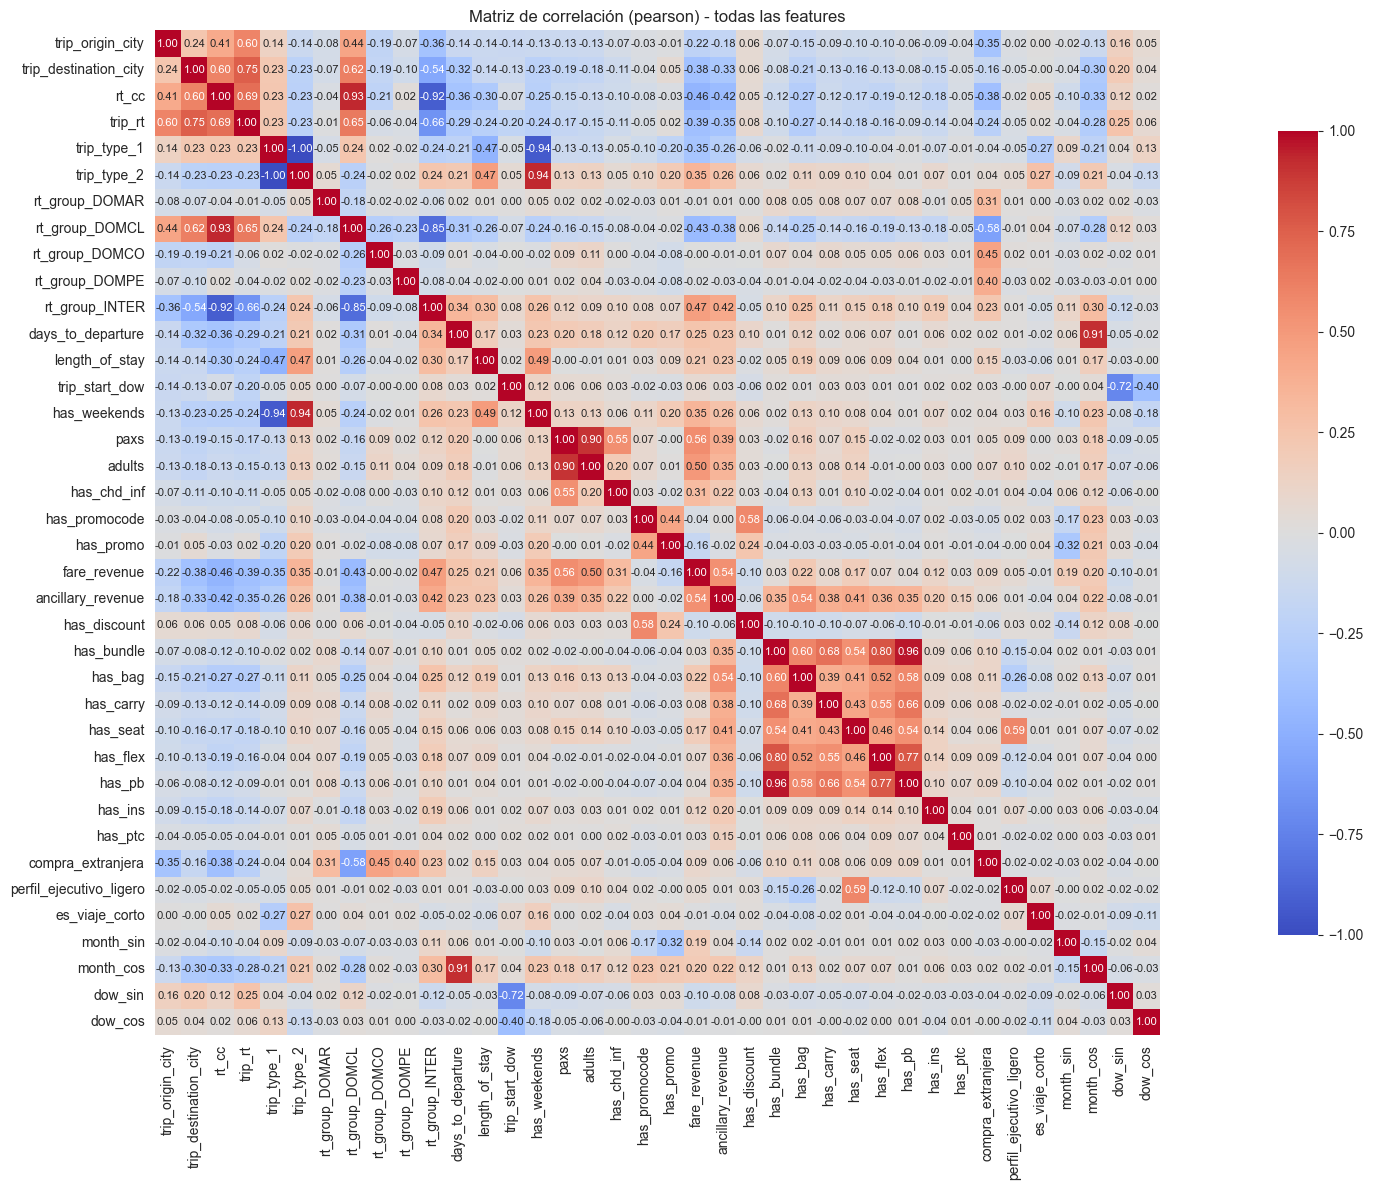

,trip_origin_city,trip_destination_city,rt_cc,trip_rt,trip_type_1,trip_type_2,rt_group_DOMAR,rt_group_DOMCL,rt_group_DOMCO,rt_group_DOMPE,rt_group_INTER,days_to_departure,length_of_stay,trip_start_dow,has_weekends,paxs,adults,has_chd_inf,has_promocode,has_promo,fare_revenue,ancillary_revenue,has_discount,has_bundle,has_bag,has_carry,has_seat,has_flex,has_pb,has_ins,has_ptc,compra_extranjera,perfil_ejecutivo_ligero,es_viaje_corto,month_sin,month_cos,dow_sin,dow_cos
trip_origin_city,1.000000,0.240691,0.410336,0.595779,0.136491,-0.136491,-0.076578,0.442267,-0.188706,-0.066227,-0.359800,-0.142491,-0.139372,-0.141915,-0.133921,-0.132991,-0.125119,-0.066583,-0.025485,-0.008771,-0.217643,-0.180767,0.057371,-0.073275,-0.148071,-0.086055,-0.104686,-0.096842,-0.061342,-0.090410,-0.036722,-0.353512,-0.024471,0.002411,-0.020874,-0.131128,0.155716,0.054771
trip_destination_city,0.240691,1.000000,0.604195,0.750609,0.225079,-0.225079,-0.073065,0.619144,-0.185060,-0.100904,-0.541333,-0.315671,-0.144954,-0.130920,-0.233613,-0.190569,-0.175388,-0.111529,-0.036408,0.053591,-0.376933,-0.327302,0.056952,-0.084574,-0.211953,-0.132653,-0.158531,-0.126521,-0.080587,-0.147814,-0.046107,-0.160713,-0.045837,-0.004591,-0.039936,-0.300491,0.197314,0.041159
rt_cc,0.410336,0.604195,1.000000,0.688059,0.230322,-0.230322,-0.036952,0.933068,-0.208929,0.015725,-0.921796,-0.359140,-0.297579,-0.067108,-0.247833,-0.152505,-0.130750,-0.103082,-0.075398,-0.027093,-0.462386,-0.420538,0.050170,-0.120473,-0.271660,-0.122956,-0.166602,-0.192061,-0.116371,-0.180308,-0.048391,-0.383609,-0.016711,0.051914,-0.096135,-0.325290,0.121953,0.017487
trip_rt,0.595779,0.750609,0.688059,1.000000,0.227212,-0.227212,-0.012621,0.646745,-0.055109,-0.037177,-0.661051,-0.294133,-0.244693,-0.200659,-0.240602,-0.172893,-0.154640,-0.111370,-0.050691,0.020033,-0.389940,-0.354320,0.077250,-0.099024,-0.266472,-0.139799,-0.179828,-0.157249,-0.089162,-0.140571,-0.039833,-0.241695,-0.046256,0.022180,-0.041472,-0.275424,0.253290,0.063301
trip_type_1,0.136491,0.225079,0.230322,0.227212,1.000000,-1.000000,-0.054876,0.235568,0.015606,-0.023047,-0.237717,-0.213180,-0.470655,-0.052691,-0.936311,-0.127275,-0.134292,-0.051998,-0.103086,-0.199309,-0.349637,-0.255485,-0.064263,-0.017423,-0.113846,-0.091713,-0.101464,-0.043974,-0.010189,-0.073131,-0.010887,-0.041284,-0.052656,-0.269498,0.090851,-0.213391,0.041628,0.125973
trip_type_2,-0.136491,-0.225079,-0.230322,-0.227212,-1.000000,1.000000,0.054876,-0.235568,-0.015606,0.023047,0.237717,0.213180,0.470655,0.052691,0.936311,0.127275,0.134292,0.051998,0.103086,0.199309,0.349637,0.255485,0.064263,0.017423,0.113846,0.091713,0.101464,0.043974,0.010189,0.073131,0.010887,0.041284,0.052656,0.269498,-0.090851,0.213391,-0.041628,-0.125973
rt_group_DOMAR,-0.076578,-0.073065,-0.036952,-0.012621,-0.054876,0.054876,1.000000,-0.180637,-0.020144,-0.017707,-0.064887,0.015051,0.014262,0.003412,0.046008,0.016129,0.023542,-0.020885,-0.025030,0.012352,-0.010661,0.012566,0.003382,0.084784,0.054627,0.075275,0.068840,0.065365,0.079527,-0.011404,0.046073,0.309814,0.010524,0.000893,-0.029372,0.021089,0.023653,-0.025856
rt_group_DOMCL,0.442267,0.619144,0.933068,0.646745,0.235568,-0.235568,-0.180637,1.000000,-0.263089,-0.231270,-0.847464,-0.310665,-0.260546,-0.071372,-0.244786,-0.157427,-0.147117,-0.080273,-0.040145,-0.016339,-0.427492,-0.380760,0.060749,-0.140955,-0.250880,-0.138392,-0.161122,-0.193793,-0.133671,-0.178382,-0.047908,-0.583050,-0.008271,0.037008,-0.071092,-0.281099,0.115753,0.026618
rt_group_DOMCO,-0.188706,-0.185060,-0.208929,-0.055109,0.015606,-0.015606,-0.020144,-0.263089,1.000000,-0.025790,-0.094504,0.014581,-0.041129,-0.003960,-0.016581,0.090452,0.110662,0.001220,-0.042222,-0.079754,-0.004993,-0.008115,-0.006251,0.070684,0.038861,0.076609,0.046942,0.053379,0.064496,0.025954,0.006067,0.451228,0.015770,0.012733,-0.028438,0.020584,-0.019621,0.008403
rt_group_DOMPE,-0.066227,-0.100904,0.015725,-0.037177,-0.023047,0.023047,-0.017707,-0.231270,-0.025790,1.000000,-0.083074

In [71]:
matriz_correlacion_por_modelo(modelo_chile, X_train_cl, target_name=y_train_gen.name)